In [1]:
import pandas as pd
import os
import re
import glob
import tiktoken
import openai
from openai import OpenAI
from scipy.spatial.distance import cosine
import os
client = OpenAI()



In [2]:
# API Key 입력. 만일 환경변수에 없으면, 프롬프트로 입력받음.
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is True:
    openai_api_key = input("OpenAI API Key 입력: ")
    os.environ["OPENAI_API_KEY"] = openai_api_key
openai.api_key = os.environ["OPENAI_API_KEY"]

In [21]:
# markdown 파일을 읽어오는 함수
def get_md_files(directory):
    md_files = glob.glob(os.path.join(directory, "**/*.md"), recursive=True)
    return md_files

# 읽어온 markdown 파일을 전처리하는 함수
def process_file_content(file_path):
    # Read and process the file content
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Replace new lines, URLs, and tags
        content = content.replace('\n', ' ').replace('\r', ' ')
        content = re.sub(r'http\S+', '', content)  # Remove URLs
        content = re.sub(r'\{\/\*.*?\*\/\}', '', content)  # Remove {/*text*/}
        content = content.replace('---', '')
        return content

In [22]:
directory = '../../raw'
md_files = get_md_files(directory)
data = []
for file_path in md_files:
    title = os.path.basename(file_path).replace('.md', '')
    content = process_file_content(file_path)
    data.append({'title': title, 'content': content})
df = pd.DataFrame(data, columns=['title', 'content'])


##  여기서부터 시작!!!!!!!!!!!
### 여기서부터 df=pd.read_csv("파일이름.csv") 로 내가 만든 데이터를 불러오기. 파일 열의 형식은 `title`, `content`이어야 한다.

In [3]:
df=pd.read_csv("C:/Users/r2com/Downloads/df.csv")

In [4]:
df

,title,content
0,애월포차,제주특별자치도 제주시 애월읍 곽지9길 23
1,오설록티뮤지엄,제주특별자치도 서귀포시 안덕면 신화역사로 15
2,함덕해수욕장,제주특별자치도 제주시 조천읍 조함해안로 525
3,제주스럽닭 서귀포올레점,제주특별자치도 서귀포시 태평로 396
4,씨에코비치,제주특별자치도 제주시 조천읍 신흥관전길 89-5
...,...,...
1993,세화마을협동조합,제주특별자치도 제주시 구좌읍 세평항로 46-9
1994,관음사휴게소,제주특별자치도 제주시 산록북로 585
1995,외계인방앗간 제주본점,제주특별자치도 제주시 월광로 107-2
1996,대빵오락실,제주특별자치도 제주시 신성로13길 21


<Axes: >

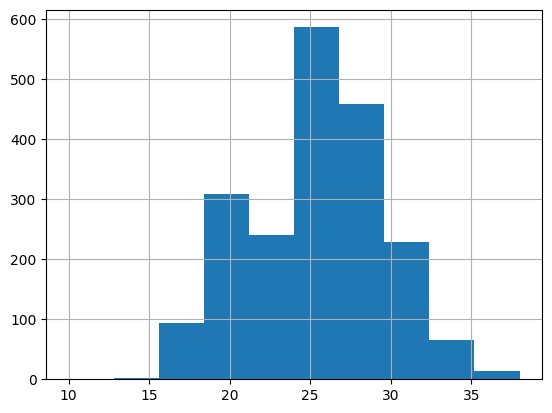

In [5]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df['content'].apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [7]:
max_tokens = 3000
def split_into_many(text, max_tokens = max_tokens):

    # 일단 문장으로 쪼개기
    sentences = text.split('. ')

    # 문장마다 몇 토큰 들어가는지 세어 주기.
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []


    for sentence, token in zip(sentences, n_tokens):

        # 문장의 토큰 수와 현재까지의 토큰 수의 합이 최대 토큰 수를 초과하면, 해당 청크를 청크 목록에 추가하고 청크 및 현재까지의 토큰 수를 초기화한다.
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1

    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks

In [8]:
shortened = []
# 데이터 프레임 순회하기
for row in df.iterrows():

    # If the content is None, go to the next row
    if row[1]['content'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the content into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['content'])
    
    # Otherwise, add the content to the list of shortened texts
    else:
        shortened.append( row[1]['content'] )

In [9]:
def split_large_text(large_text, max_tokens=2000):
    enc = tiktoken.get_encoding("cl100k_base")
    tokenized_text = enc.encode(large_text)

    chunks = []
    current_chunk = []
    current_length = 0

    for token in tokenized_text:
        current_chunk.append(token)
        current_length += 1

        if current_length >= max_tokens:
            chunks.append(enc.decode(current_chunk).rstrip(' .,;'))
            current_chunk = []
            current_length = 0

    if current_chunk:
        chunks.append(enc.decode(current_chunk).rstrip(' .,;'))

    return chunks

df['splitted_content'] = df['content'].apply(split_large_text)
df = df.explode("splitted_content")
df['spllitted_n_tokens'] = df['splitted_content'].apply(lambda x: len(tokenizer.encode(x)))
df = df.reset_index( drop=True)

In [10]:
df = df[['title','splitted_content', 'spllitted_n_tokens']].rename(columns={'splitted_content':'content', 'spllitted_n_tokens':'n_tokens'})

In [11]:
df

,title,content,n_tokens
0,애월포차,제주특별자치도 제주시 애월읍 곽지9길 23,26
1,오설록티뮤지엄,제주특별자치도 서귀포시 안덕면 신화역사로 15,29
2,함덕해수욕장,제주특별자치도 제주시 조천읍 조함해안로 525,25
3,제주스럽닭 서귀포올레점,제주특별자치도 서귀포시 태평로 396,24
4,씨에코비치,제주특별자치도 제주시 조천읍 신흥관전길 89-5,30
...,...,...,...
1993,세화마을협동조합,제주특별자치도 제주시 구좌읍 세평항로 46-9,30
1994,관음사휴게소,제주특별자치도 제주시 산록북로 585,21
1995,외계인방앗간 제주본점,제주특별자치도 제주시 월광로 107-2,22
1996,대빵오락실,제주특별자치도 제주시 신성로13길 21,21


In [12]:
def combine_info(row):
    title = " ".join(row['title'].split("-"))
    content = " ".join(row['content'].split("-"))

    
    combined = [f"title: {title}", f"content: \n{content}"]
    combined = "\n\n###\n\n".join(combined)
    
    return combined

df["combined"] = df.apply(combine_info, axis=1)

In [13]:
df

,title,content,n_tokens,combined
0,애월포차,제주특별자치도 제주시 애월읍 곽지9길 23,26,title: 애월포차\n\n###\n\ncontent: \n제주특별자치도 제주시 애...
1,오설록티뮤지엄,제주특별자치도 서귀포시 안덕면 신화역사로 15,29,title: 오설록티뮤지엄\n\n###\n\ncontent: \n제주특별자치도 서귀...
2,함덕해수욕장,제주특별자치도 제주시 조천읍 조함해안로 525,25,title: 함덕해수욕장\n\n###\n\ncontent: \n제주특별자치도 제주시...
3,제주스럽닭 서귀포올레점,제주특별자치도 서귀포시 태평로 396,24,title: 제주스럽닭 서귀포올레점\n\n###\n\ncontent: \n제주특별자...
4,씨에코비치,제주특별자치도 제주시 조천읍 신흥관전길 89-5,30,title: 씨에코비치\n\n###\n\ncontent: \n제주특별자치도 제주시 ...
...,...,...,...,...
1993,세화마을협동조합,제주특별자치도 제주시 구좌읍 세평항로 46-9,30,title: 세화마을협동조합\n\n###\n\ncontent: \n제주특별자치도 제...
1994,관음사휴게소,제주특별자치도 제주시 산록북로 585,21,title: 관음사휴게소\n\n###\n\ncontent: \n제주특별자치도 제주시...
1995,외계인방앗간 제주본점,제주특별자치도 제주시 월광로 107-2,22,title: 외계인방앗간 제주본점\n\n###\n\ncontent: \n제주특별자치...
1996,대빵오락실,제주특별자치도 제주시 신성로13길 21,21,title: 대빵오락실\n\n###\n\ncontent: \n제주특별자치도 제주시 ...


In [14]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [15]:
df["embedding"] = df.combined.apply(get_embedding)
df.to_pickle("../../processed/react-processed.pkl")

In [16]:
df = pd.read_pickle("../../processed/react-processed.pkl")

In [17]:
df

,title,content,n_tokens,combined,embedding
0,애월포차,제주특별자치도 제주시 애월읍 곽지9길 23,26,title: 애월포차\n\n###\n\ncontent: \n제주특별자치도 제주시 애...,"[-0.007431121077388525, 0.009746711701154709, ..."
1,오설록티뮤지엄,제주특별자치도 서귀포시 안덕면 신화역사로 15,29,title: 오설록티뮤지엄\n\n###\n\ncontent: \n제주특별자치도 서귀...,"[-0.00633351830765605, 0.005396116059273481, 0..."
2,함덕해수욕장,제주특별자치도 제주시 조천읍 조함해안로 525,25,title: 함덕해수욕장\n\n###\n\ncontent: \n제주특별자치도 제주시...,"[-0.016733519732952118, 0.021356554701924324, ..."
3,제주스럽닭 서귀포올레점,제주특별자치도 서귀포시 태평로 396,24,title: 제주스럽닭 서귀포올레점\n\n###\n\ncontent: \n제주특별자...,"[-0.007824063301086426, 0.013765545561909676, ..."
4,씨에코비치,제주특별자치도 제주시 조천읍 신흥관전길 89-5,30,title: 씨에코비치\n\n###\n\ncontent: \n제주특별자치도 제주시 ...,"[-0.013541909866034985, 0.0074899643659591675,..."
...,...,...,...,...,...
1993,세화마을협동조합,제주특별자치도 제주시 구좌읍 세평항로 46-9,30,title: 세화마을협동조합\n\n###\n\ncontent: \n제주특별자치도 제...,"[-0.009939388372004032, 0.01505357027053833, 0..."
1994,관음사휴게소,제주특별자치도 제주시 산록북로 585,21,title: 관음사휴게소\n\n###\n\ncontent: \n제주특별자치도 제주시...,"[-0.012339429929852486, -0.005917409434914589,..."
1995,외계인방앗간 제주본점,제주특별자치도 제주시 월광로 107-2,22,title: 외계인방앗간 제주본점\n\n###\n\ncontent: \n제주특별자치...,"[0.006557714659720659, 0.0053836992010474205, ..."
1996,대빵오락실,제주특별자치도 제주시 신성로13길 21,21,title: 대빵오락실\n\n###\n\ncontent: \n제주특별자치도 제주시 ...,"[-0.010763785801827908, 0.011689847335219383, ..."


##  여기서부터는 테스트 코드!!!!!!!!!!!!!!!!!!!
### 실제 개발환경에서 배포할 때 확인할 목적!

In [18]:
df = pd.read_pickle("../../processed/react-processed.pkl")
def create_context(
    question, df, max_len=3000
):
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding
    df["distances"] = df["embedding"].apply(lambda x: cosine(q_embeddings, x))
    returns = []
    cur_len = 0
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(row["combined"])
    return "\n\n===\n\n".join(returns)


def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="What is difference between useEffect and useLayoutEffect in React?",
    max_len=3000,
    debug=False,
):
    context = create_context(
        question,
        df,
        max_len=max_len,
    )
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"context: {context}\n\n---\n\n Question: {question}, 한국어로 대답해줘."}
            ],
            temperature=0,
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error occurred:", e)
        return ""

In [20]:
answer_question(df, question="서귀포시")

Error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens. However, your messages resulted in 4754 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


''